In [0]:
from sklearn.model_selection import cross_val_score, cross_validate

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, VarianceThreshold

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook as tqdm

import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%load_ext autotime

# I. Подготовка данных.

In [0]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1)

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [0]:
df.set_index('ID', inplace=True)

In [7]:
df.select_dtypes(exclude='object').head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [0]:
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# II. Filter methods

## 1. Mutual information

In [0]:
mutual_information = mutual_info_classif(X, y)

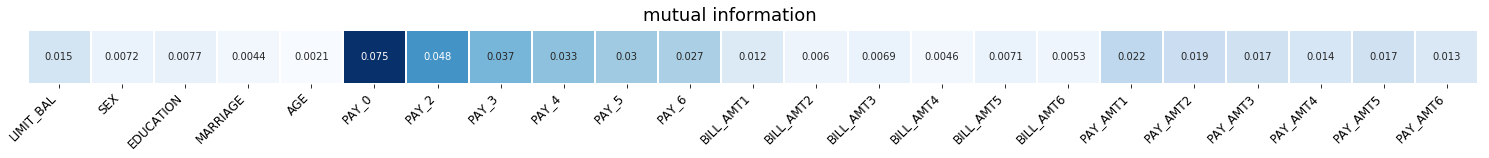

In [10]:
plt.subplots(1, figsize=(26, 1))
sns.heatmap(mutual_information.reshape(1, -1), cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(X.columns, rotation=45, ha='right', fontsize=12)
plt.suptitle("mutual information", fontsize=18, y=1.2)
plt.show()

In [0]:
mutual_information_threshold = 0.01
X_new = X[X.columns[mutual_information > mutual_information_threshold]]

In [12]:
X_new.shape

(30000, 14)

In [0]:
def gini(target, feature):
    return 2*roc_auc_score(target, feature) - 1

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.3, random_state=42, stratify=y)

# III. Modeling

In [0]:
skf_3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf_20 = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

In [0]:
xgb_params = {
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_hist'
}

In [0]:
model = xgb.XGBClassifier(**xgb_params)

In [0]:
# param_grid = {
#                 'max_depth': [7, 9, 12, 15],
#                 'subsample': [0.7, 0.8, 0.9, 1],
#                 'colsample_bytree': [0.5, 0.8, 1],
#                 'colsample_bylevel': [0.5, 0.8, 1],
#                 'min_child_weight': [0.5, 1, 2, 5],
#     }

# fit_params = {
#                 "early_stopping_rounds": 10, 
#                 "eval_metric": ['logloss', 'auc'], 
#                 "eval_set": [(X_train, y_train), (X_val, y_val)],
#                 'verbose': True
#     }

param_grid = {
                'max_depth': [4, 7, 9],
    }

In [0]:
grid_search = GridSearchCV(model, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=skf_3,
                           #fit_params=fit_params,
                           n_jobs=-1, 
                           verbose=3)

In [53]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 7, 9]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=3)

In [0]:
cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train, scoring='roc_auc', cv=skf_20, n_jobs=-1)

In [59]:
cv_results['test_score'].mean()

0.7812111990229038

time: 4.35 ms


In [60]:
col_list = X_new.columns.tolist()
i = 1
results = dict()
results['stage_0'] = dict()
results['stage_0']['all'] = cv_results['test_score'].mean()

while len(col_list) > 1:
    print('------------------------------------------------------------------------stage_' + str(i))
    tmp_res = dict()
    
    for col in tqdm(col_list):
        print(col, '---------------------------------')
        X_tmp = X_train[col_list].drop(col, axis=1)
        
        candidate_model = xgb.XGBClassifier(**xgb_params)
        candidate_grid_search = GridSearchCV(candidate_model, 
                                            param_grid=param_grid, 
                                            scoring='roc_auc', 
                                            cv=skf_3,
                                            n_jobs=-1, 
                                            verbose=3)
        candidate_grid_search.fit(X_tmp, y_train)

        cv_results = cross_validate(candidate_grid_search.best_estimator_, X_tmp, y_train, 
                                    scoring='roc_auc', cv=skf_20, n_jobs=-1)
        tmp_res[col] = cv_results['test_score'].mean()
        
    col_to_be_dropped = max(tmp_res, key=tmp_res.get)       
    col_list.remove(col_to_be_dropped)
    results['stage_' + str(i)] = tmp_res
    i += 1

------------------------------------------------------------------------stage_1


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   17.3s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.9s finished


PAY_2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.0s finished


PAY_3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.2s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.4s finished


PAY_5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.2s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.8s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.0s finished


PAY_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.1s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.0s finished


PAY_AMT3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.1s finished


PAY_AMT4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.8s finished


PAY_AMT5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.9s finished


PAY_AMT6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.8s finished


------------------------------------------------------------------------stage_2


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.2s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.6s finished


PAY_2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.9s finished


PAY_3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.7s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.7s finished


PAY_5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.4s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.6s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.8s finished


PAY_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.5s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.4s finished


PAY_AMT3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.8s finished


PAY_AMT4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.4s finished


PAY_AMT5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.6s finished


------------------------------------------------------------------------stage_3


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.1s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.2s finished


PAY_2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.4s finished


PAY_3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.9s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.7s finished


PAY_5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.6s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.6s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.8s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.3s finished


PAY_AMT3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.4s finished


PAY_AMT4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.1s finished


PAY_AMT5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.3s finished


------------------------------------------------------------------------stage_4


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.5s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.4s finished


PAY_2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.3s finished


PAY_3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.5s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.5s finished


PAY_5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.3s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.5s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.7s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.3s finished


PAY_AMT3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.0s finished


PAY_AMT4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.8s finished


------------------------------------------------------------------------stage_5


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.3s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.8s finished


PAY_2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished


PAY_3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.1s finished


PAY_5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.9s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.4s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.5s finished


PAY_AMT3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.3s finished


------------------------------------------------------------------------stage_6


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.9s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished


PAY_2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   15.0s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.9s finished


PAY_5 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.8s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.4s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.3s finished


PAY_AMT3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.3s finished


------------------------------------------------------------------------stage_7


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.1s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished


PAY_2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.5s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.9s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.6s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.4s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.3s finished


PAY_AMT3 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.4s finished


------------------------------------------------------------------------stage_8


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.8s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.2s finished


PAY_2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.4s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.4s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.6s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.3s finished


------------------------------------------------------------------------stage_9


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.6s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.3s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.6s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.1s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.9s finished


PAY_AMT2 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.0s finished


------------------------------------------------------------------------stage_10


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.4s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.0s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.8s finished


PAY_6 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.4s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   11.5s finished


------------------------------------------------------------------------stage_11


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   11.9s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.4s finished


PAY_4 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.5s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   10.8s finished


------------------------------------------------------------------------stage_12


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   11.6s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.4s finished


BILL_AMT1 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    9.3s finished


------------------------------------------------------------------------stage_13


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.0s finished


PAY_0 ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    5.2s finished


time: 38min 38s


In [61]:
pd.DataFrame(results)

,stage_0,stage_1,stage_2,stage_3,stage_4,stage_5,stage_6,stage_7,stage_8,stage_9,stage_10,stage_11,stage_12,stage_13
BILL_AMT1,NaN,0.777495,0.777713,0.778206,0.777156,0.777489,0.777391,0.776992,0.774657,0.773058,0.765722,0.762771,0.751255,NaN
LIMIT_BAL,NaN,0.774062,0.774654,0.774954,0.774311,0.774004,0.773389,0.772668,0.771695,0.769541,0.758676,0.752004,0.736542,0.711291
PAY_0,NaN,0.750416,0.750387,0.750458,0.751095,0.751939,0.751483,0.750140,0.747828,0.726316,0.716001,0.703664,0.646087,0.624214
PAY_2,NaN,0.781656,0.783010,0.783255,0.783087,0.782110,0.781520,0.780805,0.780512,NaN,NaN,NaN,NaN,NaN
PAY_3,NaN,0.782562,0.782243,0.783381,0.783406,0.783464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_4,NaN,0.781272,0.782819,0.782293,0.782524,0.782709,0.781805,0.780096,0.776848,0.774891,0.772527,0.764089,NaN,NaN
PAY_5,NaN,0.781074,0.782304,0.783404,0.783108,0.783360,0.782771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_6,NaN,0.781211,0.781034,0.782892,0.782658,0.782042,0.782147,0.778821,0.779008,0.777450,0.773829,NaN,NaN,NaN
PAY_AMT1,NaN,0.783149,0.783804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_AMT2,NaN,0.781206,0.782570,0.783076,0.783116,0.783426,0.781666,0.781162,0.780073,0.777680,NaN,NaN,NaN,NaN


time: 30.7 ms
